In [40]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt

# general libraries
import os  
import json
import time
import h5py as h5py
import copy

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf, Workspace
from scalebars import *
import deconv

In [2]:
# %matplotlib notebook
# %matplotlib widget
%matplotlib ipympl
# %matplotlib qt
plt.rcParams.update({"figure.max_open_warning": 0})
plt.rcParams['svg.fonttype'] = 'none'  # don't save font as paths (assumes font present on machine)

In [3]:
base_path = "/mnt/Data/slc4a5_roska_paper/"
with open(os.path.join(base_path, "roska_bicarbonate_wpdigi.json")) as fd:
    wpd = json.load(fd)

In [4]:
# wpd["datasetColl"][0]

In [24]:
hz = 3
dt = 1 / hz

raw = {}
for s in wpd["datasetColl"]:
    vs = np.array([pt["value"] for pt in s["data"]]).T
    vs = vs[:, np.argsort(vs[0])]  # make sure x is monotonic
    bsln = np.mean(vs[1, :10]) 
    raw[s["name"]] = vs - np.array([[vs[0, 0]], [bsln]])
    
xmaxs = np.array([np.max(vs[0]) for vs in raw.values()])
xlim = np.max(xmaxs)
xbins = np.arange(xlim // dt) * dt

d = {}
for n, vs in raw.items():
    idxs = np.digitize(vs[0], xbins, right=False)
    counts = np.bincount(idxs)  # points per bin to avg over
    binned = np.zeros(len(xbins) - 1)
    for i, idx in enumerate(idxs):
        if idx >= len(xbins):
            continue
        binned[idx - 1] += vs[1, i] / counts[idx]
    d[n] = binned

In [25]:
diff = {n: vs[1:] - vs[:-1] for n, vs in d.items()}

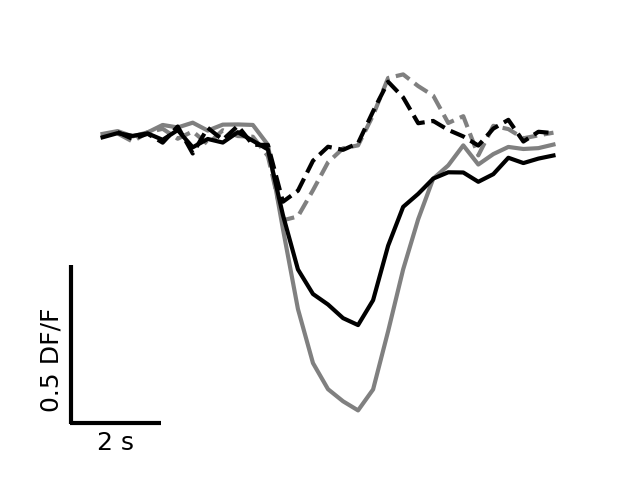

In [45]:
mouse = "WT"
mouse = "Slc4a3tm1"
lw = 3

fff, aaa = plt.subplots(1)
aaa.plot(xbins[:-1], d["%s_SS" % mouse], c="gray", lw=lw)
aaa.plot(xbins[1:-1], diff["%s_SS" % mouse], c="gray", ls="--", lw=lw)
aaa.plot(xbins[:-1], d["%s_LS" % mouse], c="black", lw=lw)
aaa.plot(xbins[1:-1], diff["%s_LS" % mouse], c="black", ls="--", lw=lw)
aaa.set_xlabel("Time (s)")
aaa.set_ylabel("DF/F")

sizex = 2
sizey = 0.5
add_scalebar(
    aaa,
    matchx=False, 
    matchy=False, 
    sizex=sizex, 
    sizey=sizey, 
    labelx="%i s" % sizex,
    labely="%.1f DF/F" % sizey,
    sep=5,
    barwidth=3,
    loc="center",
    bbox_to_anchor=(100, 120),
    textprops={"fontsize": 18},
    ytextprops={"rotation": "vertical"},
)